In [1]:
import numpy as np
import gym 
import matplotlib.pyplot as plt
from gym import spaces
import random
import time
from IPython.display import clear_output

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

In [3]:
grid = np.zeros((5,5))
pos1 = (0,0)
pos2 = (4,4)
grid[tuple(pos1)] = 1.0
grid[tuple(pos2)] = 0.5

In [4]:
class GridEnvironment(gym.Env):
    def __init__(self):
        self.observation_space=spaces.Discrete(25)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100

    def reset(self):
        self.timestep = 0
        self.initial = [0,0]
        self.goal = [4,4]
        self.state = np.zeros((5,5))
        self.state[tuple(self.initial)]=1
        self.state[tuple((1,1))]= 0.6
        self.state[tuple((2,2))]= 0.6
        self.state[tuple((3,3))]= 0.6
        self.state[tuple((4,4))]= 0.6
        self.state[tuple((0,4))]= 0.8
        self.state[tuple((4,0))]= 0.8
        self.state[tuple(self.goal)]=0.5

        observation =self.state.flatten()

        return observation

    def step(self,action):
        self.state = np.random.choice(self.observation_space.n)
        if action == 0:
            self.initial[0] +=1
        if action == 1:
            self.initial[0] -=1
        if action == 2:
            self.initial[1] +=1
        if action == 3:
            self.initial[1] -=1
        self.initial = np.clip(self.initial, 0 ,3)
        self.state = np.zeros((5,5))
        self.state[tuple(self.initial)]= 1.0
        self.state[tuple((1,1))]= 0.6
        self.state[tuple((2,2))]= 0.6
        self.state[tuple((3,3))]= 0.6
        self.state[tuple((4,4))]= 0.6
        self.state[tuple((0,4))]= 0.8
        self.state[tuple((4,0))]= 0.8
        self.state[tuple(self.goal)]= 0.5
        
        observation = self.state.flatten()

        reward = -1
        if(self.initial == self.goal).all():
            reward = 30
        if(self.initial == (1,1)).all():
            reward = 3
        if(self.initial == (2,2)).all():
            reward = 5
        if(self.initial == (3,3)).all():
            reward = 11
        if(self.initial == (4,4)).all():
            reward = 7
        if(self.initial == (0,4)).all():
            reward = -3
        if(self.initial == (4,0)).all():
            reward = -10

        self.timestep +=1 
        done = True if (self.timestep >= self.max_timesteps or (self.initial == self.goal).all()) else False 

        info ={}

        return observation, reward, done, info

    def render(self):
        plt.imshow(self.state)

In [5]:
class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.learning_rate = 0.5
        self.discount_factor = 0.9
        self.epsilon = 0.09
        self.min_epsilon = 0.001
        self.decay = 0.8
        self.batch_size = 128
        self.buffer= list()
        self.max_memory = 5000
        self.epsilon_arr = []
        self.epsilon_arr.append(self.epsilon)
        self.model = Sequential([Dense(units = 50,input_dim = state_space, activation = 'relu'),
                                 Dense(units = 256, activation = 'relu'),
                                 Dense(units = 128, activation = 'relu'),
                                 Dense(units = 512, activation = 'relu'),
                                 Dense(units = 128, activation = 'relu'),
                                 Dense(units = action_space, activation = 'sigmoid')])
        self.model.compile(loss="binary_crossentropy", optimizer = Adam(learning_rate = self.learning_rate), metrics=['accuracy'])
        
        
    def greedy(self, current_state):
        if np.random.random() < self.epsilon:
            return np.argmax(self.model.predict(current_state)[0])
        else:
            return np.random.randint(4)

    def epsilon_decay(self):
        self.epsilon = max(self.min_epsilon,(self.epsilon * self.decay))
        return self.epsilon
    
    def replay(self, current_state, action, reward, next_state, done):
        self.buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done" :done
        })
        if len(self.buffer) > self.max_memory:
            self.buffer.pop(0)
    

    def train(self):
        np.random.shuffle(self.buffer)
        sample = self.buffer[0:self.batch_size]

        for e in sample:
            current_state = self.model.predict(e["current_state"])
            reward = e["reward"]
            if not e["done"]:
                reward = reward + self.discount_factor*np.max(self.model.predict(e["next_state"])[0])
            current_state[0][e["action"]] = reward
            self.model.fit(e["current_state"], current_state, verbose=0)

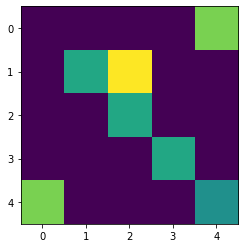

1


In [ ]:
env = GridEnvironment()
state_space = env.observation_space.n
action_space = env.action_space.n
episodes = 50
episode_count = 0;
agent = Agent(state_space, action_space)

total_rewards = 0
final_reward = 0
count = 0

epsilon_arr = list()
performance = list()
done = False
reward = 0 
for e in range(episodes):    
    current_state = env.reset()
    current_state = np.array([current_state])
    
    while (done == False or env.timestep < env.max_timesteps):
        clear_output(wait=True)
        env.render()
        plt.show()
        print(episode_count)
#         time.sleep(0.001)
        
        action = agent.greedy(current_state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array([next_state])
    
        agent.replay(current_state, action, reward, next_state, done)
        
        if done:
            agent.epsilon_decay()
            epsilon_arr.append(agent.epsilon_decay())
            break
        current_state = next_state
        total_rewards += reward
        count+=1
        
    if count >= agent.batch_size:
        agent.train()
    episode_count += 1
    final_reward += total_rewards
    performance.append(total_rewards)

print("Total Rewards - ", final_reward)
print("Performance - Total Rewards/Number of Episodes",(final_reward/episodes))

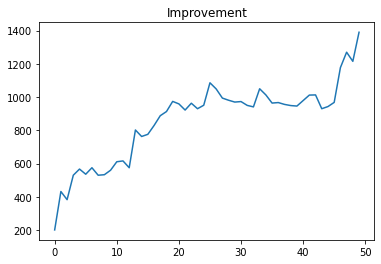

In [48]:
plt.plot(performance) 
plt.title('Improvement')
plt.show()

# MountainCar-v0

In [8]:
class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.learning_rate = 0.5
        self.discount_factor = 0.9
        self.epsilon = 0.09
        self.min_epsilon = 0.001
        self.decay = 0.8
        self.batch_size = 128
        self.buffer= list()
        self.max_memory = 5000
        self.epsilon_arr = []
        self.epsilon_arr.append(self.epsilon)
        self.model = Sequential([Dense(units=18,input_dim=state_space, activation = 'relu'),
                                 Dense(units=18,activation = 'relu'),
                                 Dense(units=action_space, activation = 'linear')])
        self.model.compile(loss="mse", optimizer = Adam(lr=self.learning_rate))
        
        
    def greedy(self, current_state):
        if np.random.random() < self.epsilon:
            return np.argmax(self.model.predict(current_state)[0])
        else:
            return np.random.randint(2)

    def epsilon_decay(self):
        self.epsilon = max(self.min_epsilon,(self.epsilon * self.decay))
        return self.epsilon
    
    def replay(self, current_state, action, reward, next_state, done):
        self.buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done" :done
        })
        if len(self.buffer) > self.max_memory:
            self.buffer.pop(0)
    

    def train(self):
        np.random.shuffle(self.buffer)
        sample = self.buffer[0:self.batch_size]

        for e in sample:
            current_state = self.model.predict(e["current_state"])
            reward = e["reward"]
            if not e["done"]:
                reward = reward + self.discount_factor*np.max(self.model.predict(e["next_state"])[0])
            current_state[0][e["action"]] = reward
            self.model.fit(e["current_state"], current_state, verbose=0)

In [9]:
import Box2D
from Box2D.b2 import (
    edgeShape,
    circleShape,
    fixtureDef,
    polygonShape,
    revoluteJointDef,
    contactListener,
)

env = gym.make('MountainCar-v0')
states = env.observation_space.shape[0]
action = env.action_space.n

In [ ]:
env = env.unwrapped
env = gym.wrappers.Monitor(env,directory='mountain-car/',force=True,write_upon_reset=True)
episodes = 100
episode_count = 0;
agent = Agent(states, action)

total_rewards = 0
final_reward = 0
count = 0

epsilon_arr = list()
performance = list()
done = False
reward = 0 
for e in range(episodes):    
    current_state = env.reset()
    current_state = np.array([current_state])
    print(e)
    while (done == False):
        clear_output(wait=True)
        time.sleep(0.01)
        plt.show()
        action = agent.greedy(current_state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array([next_state])
        agent.replay(current_state, action, reward, next_state, done)
        if done:
            agent.epsilon_decay()
            epsilon_arr.append(agent.epsilon_decay())
            break
        current_state = next_state
        total_rewards += reward
        count+=1

    if count >= agent.batch_size:    
        agent.train()
    episode_count += 1
    final_reward += total_rewards
    performance.append(total_rewards)

print("Total Rewards - ", final_reward)
print("Performance - Total Rewards/Number of Episodes",(final_reward/episodes))

0
